## 0. Prerequisites

Load default and custom Python libraries.

In [134]:
import numpy as np
import matplotlib.pyplot as plt
import os, sys
from scipy.signal import find_peaks, peak_prominences
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from pymocap.utils import _load_file
from pymocap.algo.predict_missing_markers import predict_missing_markers
from pymocap.preprocessing import _butter_lowpass_filter

Define relevant, that is where to get raw data files, and where to save processed data files.

In [135]:
# Define relevant paths
if sys.platform == "win32":
    input_data_dir = "Z:\\Keep Control\\Data\\lab dataset"
    input_json_file_name = "Z:\\Keep Control\\Output\\lab dataset\\dataset.json"
    input_csv_file_name = "Z:\\Keep Control\\Output\\lab dataset\\participants.csv"
    output_data_dir = "Z:\\Keep Control\\Data\\lab dataset\\processed"
elif sys.platform == "linux":
    input_data_dir = "/mnt/neurogeriatrics_data/Keep Control/Data/lab dataset"
    input_json_file_name = "/mnt/neurogeriatrics_data/Keep Control/Output/lab dataset/dataset.json"
    input_csv_file_name = "/mnt/neurogeriatrics_data/Keep Control/Output/lab dataset/participants.csv"
    output_data_dir = "/mnt/neurogeriatrics_data/Keep Control/Data/lab dataset/processed"
else:
    raise ValueError(f"Unknown system platform: {sys.platform}")

## 1. Get the Data

In [136]:
# Get folders from input data directory
participant_ids = [folder_name for folder_name in os.listdir(input_data_dir) if folder_name.startswith("pp")]

In [137]:
# Select a random participant by its participant id
ix_participant_id = np.random.choice(len(participant_ids), replace=False, size=1)[0]
participant_id = participant_ids[ix_participant_id]
print(participant_id)

pp050


In [138]:
# Get all available optical motion capture filenames
filenames = [fname for fname in os.listdir(os.path.join(input_data_dir, participant_id, "optical")) if fname.endswith(".mat")]


In [139]:
# Get the data from the 5 meter walking trial at preferred gait speed
ix_filename = filenames.index("omc_walk_preferred.mat")
filename = filenames[ix_filename]

In [140]:
# Load the optical motion capture data
omc_data = _load_file(os.path.join(input_data_dir, participant_id, "optical", filename))

In [141]:
# Get indexes of relevant markers
ix_l_heel = omc_data["marker_location"].tolist().index("l_heel")
ix_l_toe  = omc_data["marker_location"].tolist().index("l_toe")
ix_r_heel = omc_data["marker_location"].tolist().index("r_heel")
ix_r_toe  = omc_data["marker_location"].tolist().index("r_toe")

In [142]:
# Find start and end index for which all data of relevant markers is available
ix_first = np.argwhere(np.all(np.logical_not(np.isnan(omc_data["pos"][:,0,[ix_l_heel,ix_l_toe,ix_r_heel,ix_r_toe]])), axis=1))[:,0][0]
ix_last = np.argwhere(np.all(np.logical_not(np.isnan(omc_data["pos"][:,0,[ix_l_heel,ix_l_toe,ix_r_heel,ix_r_toe]])), axis=1))[:,0][-1]

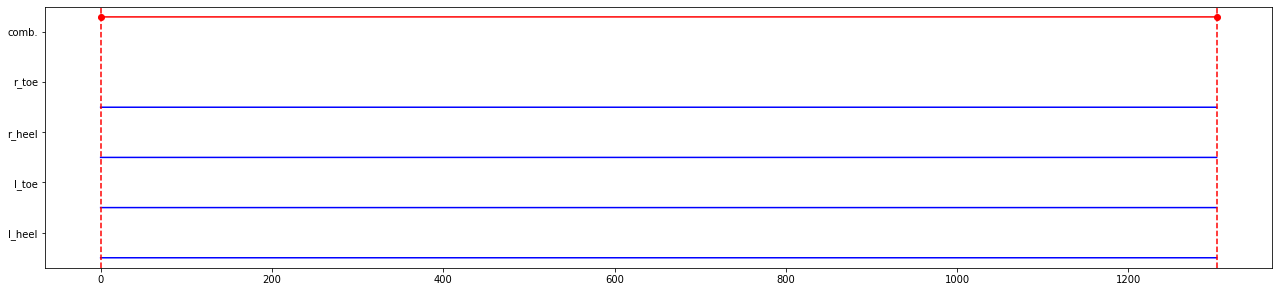

In [143]:
# Plot marker data availability
fig, axs = plt.subplots(1, 1, figsize=(22, 4.8))
axs.plot(.8*np.isnan(omc_data["pos"][:,0,ix_l_heel]), 'b-')
axs.plot(1+.8*np.isnan(omc_data["pos"][:,0,ix_l_toe]), 'b-')
axs.plot(2+.8*np.isnan(omc_data["pos"][:,0,ix_r_heel]), 'b-')
axs.plot(3+.8*np.isnan(omc_data["pos"][:,0,ix_r_toe]), 'b-')
axs.plot(4+.8*np.all(np.logical_not(np.isnan(omc_data["pos"][:,0,[ix_l_heel,ix_l_toe,ix_r_heel,ix_r_toe]])), axis=1), 'r-')
axs.plot(ix_first, 4+.8, 'ro')
axs.plot(ix_last, 4+.8, 'ro')
axs.plot([ix_first, ix_first], [-0.2, 5], 'r--')
axs.plot([ix_last, ix_last], [-0.2, 5], 'r--')
axs.set_yticks((0.5, 1.5, 2.5, 3.5, 4.5))
axs.set_yticklabels(['l_heel', 'l_toe', 'r_heel', 'r_toe', 'comb.'])
axs.set_ylim((-0.2, 5))
plt.show()

In [144]:
omc_data["pos"][ix_first:ix_last,:3,:].shape

(1303, 3, 51)

In [145]:
ix_last-ix_first

1303

In [146]:
print(f"Shape of initial array: {omc_data['pos'].shape}")

# Get the raw marker position data, and reshape in suitable format, dividing by 1000 to get position (in m)
raw_positions = np.reshape(omc_data["pos"][ix_first:ix_last,:3,:], ((ix_last-ix_first), 3*omc_data["pos"].shape[2]), order='F')/1000
print(f"Shape of raw positions array: {raw_positions.shape}")

Shape of initial array: (1304, 4, 51)
Shape of raw positions array: (1303, 153)


In [147]:
# Interpolate marker trajectories to account for missing marker data
interpolated_positions = predict_missing_markers(raw_positions)

# Lowpass filter (dual-pass) with 4th order Butterworth filter at 6 Hz cut-off (Bruening et al., 2014)
fc = 7  # cut-off frequency (Hz)
filtered_positions = _butter_lowpass_filter(interpolated_positions, omc_data["fs"], fc)

In [148]:
# Calculate velocities and accelerations
interpolated_velocities = np.diff(interpolated_positions, n=1, axis=0)/(1/omc_data["fs"])
interpolated_accelerations = np.diff(interpolated_velocities, n=1, axis=0)/(1/omc_data["fs"])
filtered_velocities = np.diff(filtered_positions, n=1, axis=0)/(1/omc_data["fs"])
filteded_accelerations = np.diff(filtered_velocities, n=1, axis=0)/(1/omc_data["fs"])

# Calculate midfoot
l_midfoot_pos = ( filtered_positions[:, ix_l_heel*3:ix_l_heel*3+3] + filtered_positions[:, ix_l_toe*3:ix_l_toe*3+3] ) / 2
r_midfoot_pos = ( filtered_positions[:, ix_r_heel*3:ix_r_heel*3+3] + filtered_positions[:, ix_r_toe*3:ix_r_toe*3+3] ) / 2
l_midfoot_vel = np.diff(l_midfoot_pos, n=1, axis=0)/(1/omc_data["fs"])
r_midfoot_vel = np.diff(r_midfoot_pos, n=1, axis=0)/(1/omc_data["fs"])
l_midfoot_acc = np.diff(l_midfoot_vel, n=1, axis=0)/(1/omc_data["fs"])
r_midfoot_acc = np.diff(l_midfoot_vel, n=1, axis=0)/(1/omc_data["fs"])

# Find local max in vertical position of heel marker
z_min = np.min([np.min(filtered_positions[:,ix_l_heel*3+2]), np.min(filtered_positions[:,ix_r_heel*3+2])])
z_max = np.max([np.max(filtered_positions[:,ix_l_heel*3+2]), np.max(filtered_positions[:,ix_r_heel*3+2])])
z_range = (z_max - z_min)
ix_max_l_heel_pos_z, props_max_l_heel_pos_z = find_peaks(filtered_positions[:,ix_l_heel*3+2], height=z_min+0.1*z_range, distance=omc_data["fs"]//2)
ix_max_r_heel_pos_z, props_max_r_heel_pos_z = find_peaks(filtered_positions[:,ix_r_heel*3+2], height=z_min+0.1*z_range, distance=omc_data["fs"]//2)
proms_max_l_heel_pos_z = peak_prominences(filtered_positions[:,ix_l_heel*3+2], ix_max_l_heel_pos_z)
proms_max_r_heel_pos_z = peak_prominences(filtered_positions[:,ix_r_heel*3+2], ix_max_r_heel_pos_z)

# Find peaks in the forward velocity
ix_max_l_heel_vel_x, props_max_l_heel_vel_x = find_peaks(filtered_velocities[:,3*ix_l_heel], height=0, distance=omc_data["fs"]//2)
ix_max_r_heel_vel_x, props_max_r_heel_vel_x = find_peaks(filtered_velocities[:,3*ix_r_heel], height=0, distance=omc_data["fs"]//2)
proms_max_l_heel_vel_x = peak_prominences(filtered_velocities[:,ix_l_heel*3], ix_max_l_heel_vel_x)
proms_max_r_heel_vel_x = peak_prominences(filtered_velocities[:,ix_r_heel*3], ix_max_r_heel_vel_x)

# Find peaks in the vertical velocity
ix_max_l_heel_vel_z, props_max_l_heel_vel_z = find_peaks(filtered_velocities[:,3*ix_l_heel+2], height=0, distance=omc_data["fs"]//2)
ix_max_r_heel_vel_z, props_max_r_heel_vel_z = find_peaks(filtered_velocities[:,3*ix_r_heel+2], height=0, distance=omc_data["fs"]//2)
proms_max_l_heel_vel_z = peak_prominences(filtered_velocities[:,ix_l_heel*3+2], ix_max_l_heel_vel_z)
proms_max_r_heel_vel_z = peak_prominences(filtered_velocities[:,ix_r_heel*3+2], ix_max_r_heel_vel_z)
ix_min_l_heel_vel_z, props_min_l_heel_vel_z = find_peaks(-filtered_velocities[:,3*ix_l_heel+2], height=0, distance=omc_data["fs"]//2)
ix_min_r_heel_vel_z, props_min_r_heel_vel_z = find_peaks(-filtered_velocities[:,3*ix_r_heel+2], height=0, distance=omc_data["fs"]//2)
proms_min_l_heel_vel_z = peak_prominences(filtered_velocities[:,ix_l_heel*3+2], ix_min_l_heel_vel_z)
proms_min_r_heel_vel_z = peak_prominences(filtered_velocities[:,ix_r_heel*3+2], ix_min_r_heel_vel_z)

In [149]:
# Threshold local maxima based on 10% threshold of peak prominence
thr = 0.10
ix_max_l_heel_pos_z = ix_max_l_heel_pos_z[proms_max_l_heel_pos_z[0] >= thr*np.max(proms_max_l_heel_pos_z[0])]
ix_max_r_heel_pos_z = ix_max_r_heel_pos_z[proms_max_r_heel_pos_z[0] >= thr*np.max(proms_max_r_heel_pos_z[0])]
ix_max_l_heel_vel_x = ix_max_l_heel_vel_x[proms_max_l_heel_vel_x[0] >= thr*np.max(proms_max_l_heel_vel_x[0])]
ix_max_r_heel_vel_x = ix_max_r_heel_vel_x[proms_max_r_heel_vel_x[0] >= thr*np.max(proms_max_r_heel_vel_x[0])]
ix_max_l_heel_vel_z = ix_max_l_heel_vel_z[proms_max_l_heel_vel_z[0] >= thr*np.max(proms_max_l_heel_vel_z[0])]
ix_max_r_heel_vel_z = ix_max_r_heel_vel_z[proms_max_r_heel_vel_z[0] >= thr*np.max(proms_max_r_heel_vel_z[0])]
ix_min_l_heel_vel_z = ix_min_l_heel_vel_z[proms_min_l_heel_vel_z[0] >= thr*np.max(proms_min_l_heel_vel_z[0])]
ix_min_r_heel_vel_z = ix_min_r_heel_vel_z[proms_min_r_heel_vel_z[0] >= thr*np.max(proms_min_r_heel_vel_z[0])]

In [151]:
fig = make_subplots(rows = 3, cols = 1, shared_xaxes=True)

# Left heel positions
fig.add_trace(go.Scatter(x=np.arange(omc_data["pos"].shape[0])/omc_data["fs"], y=omc_data["pos"][:,2,ix_l_heel]/1000, mode='lines', line=dict(color='rgba(0,0,255,0.2)', width=3), name='Z pos (raw)'), row=1, col=1)
fig.add_trace(go.Scatter(x=np.arange(interpolated_positions.shape[0])/omc_data["fs"], y=interpolated_positions[:,3*ix_l_heel+2], mode='lines', line=dict(color='rgba(0,0,255,1)', width=1), name='Z pos (interp.)'), row=1, col=1)
fig.add_trace(go.Scatter(x=np.arange(filtered_positions.shape[0])/omc_data["fs"], y=filtered_positions[:,3*ix_l_heel+2], mode='lines', line=dict(color='rgba(0,0,255,1)', width=1), name='Z pos (filt.)'), row=1, col=1)
fig.add_trace(go.Scatter(x=np.arange(filtered_positions.shape[0])/omc_data["fs"], y=filtered_positions[:,3*ix_l_toe+2], mode='lines', line=dict(color='rgba(0,0,255,1)', width=1, dash='dot'), name='Z pos (filt.)'), row=1, col=1)
fig.add_trace(go.Scatter(x=np.arange(filtered_positions.shape[0])/omc_data["fs"], y=filtered_positions[:,3*ix_r_toe+2], mode='lines', line=dict(color='rgba(255,0,0,1)', width=1, dash='dot'), name='Z pos (filt.)'), row=1, col=1)
fig.add_trace(go.Scatter(x=ix_max_l_heel_pos_z/omc_data["fs"], y=filtered_positions[ix_max_l_heel_pos_z,3*ix_l_heel+2], mode='markers', marker=dict(color='rgba(0,0,255,0.5)', size=8), name='Z pos (filt.)'), row=1, col=1)
fig.add_trace(go.Scatter(x=ix_min_l_heel_vel_z/omc_data["fs"], y=filtered_positions[ix_min_l_heel_vel_z,3*ix_l_toe+2], mode='markers', marker=dict(color='rgba(0, 0, 255, 1)', size=8, symbol='triangle-down-open'), name='Z vel pks'), row=1, col=1)
fig.add_trace(go.Scatter(x=ix_min_r_heel_vel_z/omc_data["fs"], y=filtered_positions[ix_min_r_heel_vel_z,3*ix_r_toe+2], mode='markers', marker=dict(color='rgba(255, 0, 0, 1)', size=8, symbol='triangle-down-open'), name='Z vel pks'), row=1, col=1)
# fig.add_trace(go.Scatter(x=left_bounds/omc_data["fs"], y=filtered_positions[left_bounds,3*ix_l_heel+2], mode='markers', marker=dict(color='rgba(0, 0, 255, 1)', symbol='cross', size=8), name='AP left bounds'), row=1, col=1)
# fig.add_trace(go.Scatter(x=right_bounds/omc_data["fs"], y=filtered_positions[right_bounds,3*ix_l_heel+2], mode='markers', marker=dict(color='rgba(0, 0, 255, 1)', symbol='cross', size=8), name='AP left bounds'), row=1, col=1)

# Right heel positions
fig.add_trace(go.Scatter(x=np.arange(omc_data["pos"].shape[0])/omc_data["fs"], y=omc_data["pos"][:,2,ix_r_heel]/1000, mode='lines', line=dict(color='rgba(255,0,0,0.2)', width=3), name='Z pos (raw)'), row=1, col=1)
fig.add_trace(go.Scatter(x=np.arange(interpolated_positions.shape[0])/omc_data["fs"], y=interpolated_positions[:,3*ix_r_heel+2], mode='lines', line=dict(color='rgba(255,0,0,1)', width=1), name='Z pos (interp.)'), row=1, col=1)
fig.add_trace(go.Scatter(x=np.arange(filtered_positions.shape[0])/omc_data["fs"], y=filtered_positions[:,3*ix_r_heel+2], mode='lines', line=dict(color='rgba(255,0,0,1)', width=1), name='Z pos (filt.)'), row=1, col=1)
fig.add_trace(go.Scatter(x=ix_max_r_heel_pos_z/omc_data["fs"], y=filtered_positions[ix_max_r_heel_pos_z,3*ix_r_heel+2], mode='markers', marker=dict(color='rgba(255,0,0,0.5)', size=8), name='Z pos (filt.)'), row=1, col=1)

# Left heel velocities - forward
fig.add_trace(go.Scatter(x=np.arange(filtered_velocities.shape[0])/omc_data["fs"], y=filtered_velocities[:,3*ix_l_heel], mode='lines', line=dict(color='rgba(0,0,255,1)', width=1), name='AP vel (filt.)'), row=2, col=1)
fig.add_trace(go.Scatter(x=ix_max_l_heel_pos_z/omc_data["fs"], y=filtered_velocities[ix_max_l_heel_pos_z,3*ix_l_heel], mode='markers', marker=dict(color='rgba(0,0,255,0.5)', size=8), name='AP vel (filt.)'), row=2, col=1)
fig.add_trace(go.Scatter(x=ix_max_l_heel_vel_x/omc_data["fs"], y=filtered_velocities[ix_max_l_heel_vel_x,3*ix_l_heel], mode='markers', marker=dict(color='rgba(0, 0, 255, 1)', size=8, symbol='square-open'), name='AP vel pks'), row=2, col=1)
# fig.add_trace(go.Scatter(x=left_bounds/omc_data["fs"], y=filtered_velocities[left_bounds,3*ix_l_heel], mode='markers', marker=dict(color='rgba(0, 0, 255, 1)', symbol='cross', size=8), name='AP left bounds'), row=2, col=1)
# fig.add_trace(go.Scatter(x=right_bounds/omc_data["fs"], y=filtered_velocities[right_bounds,3*ix_l_heel], mode='markers', marker=dict(color='rgba(0, 0, 255, 1)', symbol='cross', size=8), name='AP right bounds'), row=2, col=1)

# Right heel velocities - forward
fig.add_trace(go.Scatter(x=np.arange(filtered_velocities.shape[0])/omc_data["fs"], y=filtered_velocities[:,3*ix_r_heel], mode='lines', line=dict(color='rgba(255,0,0,1)', width=1), name='AP vel (filt.)'), row=2, col=1)
fig.add_trace(go.Scatter(x=ix_max_r_heel_pos_z/omc_data["fs"], y=filtered_velocities[ix_max_r_heel_pos_z,3*ix_r_heel], mode='markers', marker=dict(color='rgba(255,0,0,0.5)', size=8), name='AP vel (filt.)'), row=2, col=1)
fig.add_trace(go.Scatter(x=ix_max_r_heel_vel_x/omc_data["fs"], y=filtered_velocities[ix_max_r_heel_vel_x,3*ix_r_heel], mode='markers', marker=dict(color='rgba(255, 0, 0, 1)', size=8, symbol='square-open'), name='AP vel pks'), row=2, col=1)

# Midfoot velocities - forward
fig.add_trace(go.Scatter(x=np.arange(l_midfoot_vel.shape[0])/omc_data["fs"], y=l_midfoot_vel[:,0], mode='lines', line=dict(color='rgba(0, 0, 255, 1)', dash='longdashdot'), name='mid foot'), row=2, col=1)
fig.add_trace(go.Scatter(x=np.arange(r_midfoot_vel.shape[0])/omc_data["fs"], y=r_midfoot_vel[:,0], mode='lines', line=dict(color='rgba(255, 0, 0, 1)', dash='longdashdot'), name='mid foot'), row=2, col=1)

# Left heel velocities - vertical
fig.add_trace(go.Scatter(x=np.arange(filtered_velocities.shape[0])/omc_data["fs"], y=filtered_velocities[:,3*ix_l_heel+2], mode='lines', line=dict(color='rgba(0,0,255,1)', width=1), name='AP vel (filt.)'), row=3, col=1)
fig.add_trace(go.Scatter(x=ix_max_l_heel_pos_z/omc_data["fs"], y=filtered_velocities[ix_max_l_heel_pos_z,3*ix_l_heel+2], mode='markers', marker=dict(color='rgba(0,0,255,0.5)', size=8), name='AP vel (filt.)'), row=3, col=1)
fig.add_trace(go.Scatter(x=ix_max_l_heel_vel_x/omc_data["fs"], y=filtered_velocities[ix_max_l_heel_vel_x,3*ix_l_heel+2], mode='markers', marker=dict(color='rgba(0, 0, 255, 1)', size=8, symbol='square-open'), name='AP vel pks'), row=3, col=1)
fig.add_trace(go.Scatter(x=ix_max_l_heel_vel_z/omc_data["fs"], y=filtered_velocities[ix_max_l_heel_vel_z,3*ix_l_heel+2], mode='markers', marker=dict(color='rgba(0, 0, 255, 1)', size=8, symbol='triangle-up-open'), name='Z vel pks'), row=3, col=1)
fig.add_trace(go.Scatter(x=ix_min_l_heel_vel_z/omc_data["fs"], y=filtered_velocities[ix_min_l_heel_vel_z,3*ix_l_heel+2], mode='markers', marker=dict(color='rgba(0, 0, 255, 1)', size=8, symbol='triangle-down-open'), name='Z vel pks'), row=3, col=1)
# fig.add_trace(go.Scatter(x=left_bounds/omc_data["fs"], y=filtered_velocities[left_bounds,3*ix_l_heel+2], mode='markers', marker=dict(color='rgba(0, 0, 255, 1)', symbol='cross', size=8), name='AP left bounds'), row=3, col=1)
# fig.add_trace(go.Scatter(x=right_bounds/omc_data["fs"], y=filtered_velocities[right_bounds,3*ix_l_heel+2], mode='markers', marker=dict(color='rgba(0, 0, 255, 1)', symbol='cross', size=8), name='AP right bounds'), row=3, col=1)

# Right heel velocities - vertical
fig.add_trace(go.Scatter(x=np.arange(filtered_velocities.shape[0])/omc_data["fs"], y=filtered_velocities[:,3*ix_r_heel+2], mode='lines', line=dict(color='rgba(255,0,0,1)', width=1), name='AP vel (filt.)'), row=3, col=1)
fig.add_trace(go.Scatter(x=ix_max_r_heel_pos_z/omc_data["fs"], y=filtered_velocities[ix_max_r_heel_pos_z,3*ix_r_heel+2], mode='markers', marker=dict(color='rgba(255,0,0,0.5)', size=8), name='AP vel (filt.)'), row=3, col=1)
fig.add_trace(go.Scatter(x=ix_max_r_heel_vel_x/omc_data["fs"], y=filtered_velocities[ix_max_r_heel_vel_x,3*ix_r_heel+2], mode='markers', marker=dict(color='rgba(255, 0, 0, 1)', size=8, symbol='square-open'), name='AP vel pks'), row=3, col=1)
fig.add_trace(go.Scatter(x=ix_max_r_heel_vel_z/omc_data["fs"], y=filtered_velocities[ix_max_r_heel_vel_z,3*ix_r_heel+2], mode='markers', marker=dict(color='rgba(255, 0, 0, 1)', size=8, symbol='triangle-up-open'), name='Z vel pks'), row=3, col=1)
fig.add_trace(go.Scatter(x=ix_min_r_heel_vel_z/omc_data["fs"], y=filtered_velocities[ix_min_r_heel_vel_z,3*ix_r_heel+2], mode='markers', marker=dict(color='rgba(255, 0, 0, 1)', size=8, symbol='triangle-down-open'), name='Z vel pks'), row=3, col=1)

fig.update_layout(width=1200, height=640, margin=dict(l=10, r=10, b=20))
fig.show()

In [152]:
my_markers = ["l_heel", "l_toe", "r_heel", "r_toe"]

ix_a, ix_b = [], []
for mrk in my_markers:
    ix = omc_data["marker_location"].tolist().index(mrk)
    ix_a.append(np.argwhere(np.logical_not(np.isnan(omc_data['pos'][:,0,ix])))[:,0][0])
    ix_b.append(np.argwhere(np.logical_not(np.isnan(omc_data['pos'][:,0,ix])))[:,0][-1])
    print(f"{mrk:>8s}: {ix:>4d} {np.argwhere(np.logical_not(np.isnan(omc_data['pos'][:,0,ix])))[:,0]}")

  l_heel:    1 [   0    1    2 ... 1301 1302 1303]
   l_toe:    0 [   0    1    2 ... 1301 1302 1303]
  r_heel:   12 [   0    1    2 ... 1301 1302 1303]
   r_toe:   11 [   0    1    2 ... 1301 1302 1303]


In [ ]:
ix_a

[349, 0, 385, 0]

In [ ]:
ix_b

[1592, 1592, 1592, 1592]